# RTC System Data
## Import Libraries

In [1]:
# Upgrade command
!pip install --upgrade pip

# Install Requests
!pip install requests

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import json
import requests
import datetime
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from collections import namedtuple
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pyplot import figure

### Latitude, Longitude & TZ

In [3]:
# Specify Location (Albuquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

## Accessing API with Pandas
### Weather and System Data

In [4]:
# Get Weather Data from URL - June 21
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/weather/start/2020-06-21/end/2020-06-22/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
weather_df = pd.DataFrame(response.json())
weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,RainDailyAccumilation,RelativeHumidity,TmStamp,WindDirection,WindSpeed
0,24.020000,-7.531733,-0.069005,-6.521352,0.0,12.76,1592697660000,74.919998,3.452
1,24.030001,-7.444839,0.107732,-6.604334,0.0,13.05,1592697720000,70.290001,3.094
2,23.969999,-6.903023,0.185531,-6.559282,0.0,13.16,1592697780000,66.760002,2.594
3,23.990000,-7.217169,0.223914,-6.579042,0.0,13.35,1592697840000,66.070000,2.394
4,24.070000,-7.340383,0.129744,-6.535753,0.0,13.20,1592697900000,51.959999,2.626


In [5]:
# Drop unnecessary data
weather_df.drop(['RainDailyAccumilation', 'RelativeHumidity', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,TmStamp
0,24.020000,-7.531733,-0.069005,-6.521352,1592697660000
1,24.030001,-7.444839,0.107732,-6.604334,1592697720000
2,23.969999,-6.903023,0.185531,-6.559282,1592697780000
3,23.990000,-7.217169,0.223914,-6.579042,1592697840000
4,24.070000,-7.340383,0.129744,-6.535753,1592697900000


In [6]:
weather_df.rename(columns={'TmStamp':'TimeStamp', 'GlobalIrrad':'GHI', 'DirectIrrad':'DNI', 'DiffuseIrrad':'DHI'}, inplace=True)

In [7]:
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,24.020000,-7.531733,-0.069005,-6.521352,1592697660000
1,24.030001,-7.444839,0.107732,-6.604334,1592697720000
2,23.969999,-6.903023,0.185531,-6.559282,1592697780000
3,23.990000,-7.217169,0.223914,-6.579042,1592697840000
4,24.070000,-7.340383,0.129744,-6.535753,1592697900000


In [8]:
# Examine the types of the column labels
all(isinstance(column, str) for column in weather_df.columns)

True

In [9]:
weather_df['TimeStamp'] =  pd.to_datetime(weather_df['TimeStamp']/1000, unit='s')
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,24.020000,-7.531733,-0.069005,-6.521352,2020-06-21 00:01:00
1,24.030001,-7.444839,0.107732,-6.604334,2020-06-21 00:02:00
2,23.969999,-6.903023,0.185531,-6.559282,2020-06-21 00:03:00
3,23.990000,-7.217169,0.223914,-6.579042,2020-06-21 00:04:00
4,24.070000,-7.340383,0.129744,-6.535753,2020-06-21 00:05:00


In [10]:
# TimeStamp as Index
weather_df.set_index('TimeStamp', inplace=True)
weather_df.head()

,AmbientTemp,DHI,DNI,GHI
TimeStamp,,,,
2020-06-21 00:01:00,24.020000,-7.531733,-0.069005,-6.521352
2020-06-21 00:02:00,24.030001,-7.444839,0.107732,-6.604334
2020-06-21 00:03:00,23.969999,-6.903023,0.185531,-6.559282
2020-06-21 00:04:00,23.990000,-7.217169,0.223914,-6.579042
2020-06-21 00:05:00,24.070000,-7.340383,0.129744,-6.535753


In [11]:
# Weather Keys
print("Keys of weather_df: \n{}".format(weather_df.keys()))

Keys of weather_df: 
Index(['AmbientTemp', 'DHI', 'DNI', 'GHI'], dtype='object')


In [12]:
# Analyzing Data - June 21
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
weather_df.describe()

,AmbientTemp,DHI,DNI,GHI
count,1439.000000,1439.000000,1439.000000,1439.000000
mean,28.544093,50.883560,415.169285,353.127306
std,5.526755,57.296374,415.380667,405.853728
min,19.080000,-11.723736,-0.315936,-7.511187
25%,23.474999,-7.355397,0.144764,-6.422298
50%,28.799999,54.132263,292.029846,121.733803
75%,34.105000,95.302074,874.594849,769.916718
max,36.869999,205.207413,976.172852,1051.414307


In [13]:
weather_df_slice = weather_df.iloc[::5] 

## System

In [14]:
# Get System Data from URL - June 21
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/system/start/2020-06-21/end/2020-06-22/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
system_df = pd.DataFrame(response.json())
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TmStamp
0,22.941666,-2.703747,0.0,0.0,-0.045,2.400000,-2.643684,0.006,1.8,0.0,1592697660000
1,22.891665,-2.607184,0.0,0.0,-0.045,2.400000,-2.716874,0.006,1.8,0.0,1592697720000
2,22.833334,-2.414059,0.0,0.0,-0.045,2.400000,-2.349657,0.006,1.8,0.0,1592697780000
3,22.875000,-2.800309,0.0,0.0,-0.045,2.400000,-2.349275,0.006,1.8,0.0,1592697840000
4,22.900000,-3.476246,0.0,0.0,-0.045,2.383333,-2.422315,0.006,1.8,0.0,1592697900000


In [15]:
# System Keys
print("Keys of system_df: \n{}".format(system_df.keys()))

Keys of system_df: 
Index(['AmbientTemp', 'PyranometerIrrad', 'RefCell1Irrad', 'RefCell2Irrad',
       'Sys1Idc', 'Sys1Vdc', 'Sys1Wac', 'Sys2Idc', 'Sys2Vdc', 'Sys2Wac',
       'TmStamp'],
      dtype='object')


In [16]:
system_df.rename(columns={'TmStamp':'TimeStamp'}, inplace=True)

In [17]:
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,22.941666,-2.703747,0.0,0.0,-0.045,2.400000,-2.643684,0.006,1.8,0.0,1592697660000
1,22.891665,-2.607184,0.0,0.0,-0.045,2.400000,-2.716874,0.006,1.8,0.0,1592697720000
2,22.833334,-2.414059,0.0,0.0,-0.045,2.400000,-2.349657,0.006,1.8,0.0,1592697780000
3,22.875000,-2.800309,0.0,0.0,-0.045,2.400000,-2.349275,0.006,1.8,0.0,1592697840000
4,22.900000,-3.476246,0.0,0.0,-0.045,2.383333,-2.422315,0.006,1.8,0.0,1592697900000


In [18]:
system_df.tail()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
1434,24.041666,-2.317497,0.0,0.0,-0.045,2.2,-2.350472,0.006,1.616667,0.0,1592783700000
1435,23.966665,-2.317497,0.0,0.0,-0.045,2.2,-2.717807,0.006,1.600000,0.0,1592783760000
1436,23.908333,-2.317497,0.0,0.0,-0.045,2.2,-2.497897,0.006,1.600000,0.0,1592783820000
1437,23.791666,-2.317497,0.0,0.0,-0.045,2.2,-2.571274,0.006,1.600000,0.0,1592783880000
1438,23.675001,-2.317497,0.0,0.0,-0.045,2.2,-2.424258,0.006,1.600000,0.0,1592783940000


In [19]:
# Examine the types of the column labels
all(isinstance(column, str) for column in system_df.columns)

True

In [20]:
system_df['TimeStamp'] =  pd.to_datetime(system_df['TimeStamp']/1000, unit='s')
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,22.941666,-2.703747,0.0,0.0,-0.045,2.400000,-2.643684,0.006,1.8,0.0,2020-06-21 00:01:00
1,22.891665,-2.607184,0.0,0.0,-0.045,2.400000,-2.716874,0.006,1.8,0.0,2020-06-21 00:02:00
2,22.833334,-2.414059,0.0,0.0,-0.045,2.400000,-2.349657,0.006,1.8,0.0,2020-06-21 00:03:00
3,22.875000,-2.800309,0.0,0.0,-0.045,2.400000,-2.349275,0.006,1.8,0.0,2020-06-21 00:04:00
4,22.900000,-3.476246,0.0,0.0,-0.045,2.383333,-2.422315,0.006,1.8,0.0,2020-06-21 00:05:00


In [21]:
system_df.drop(system_df.index[range(0, 340)], axis=0, inplace=True)

In [22]:
system_df.drop(system_df.index[range(1019, 1099)], axis=0, inplace=True)

In [23]:
# TimeStamp as Index
system_df.set_index('TimeStamp', inplace=True)
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-21 05:41:00,19.016666,32.831207,32.550571,31.860306,0.22100,325.399994,59.827648,0.24325,363.199982,66.643379
2020-06-21 05:42:00,19.241667,33.603706,33.129814,32.389091,0.22700,323.666656,60.707169,0.24875,363.033325,68.394920
2020-06-21 05:43:00,19.316668,34.472767,33.708828,32.961937,0.23075,325.883331,62.539989,0.25425,362.449982,70.088669
2020-06-21 05:44:00,19.500000,34.762455,34.135765,33.431591,0.23425,327.149994,64.669312,0.25900,362.033325,70.528603
2020-06-21 05:45:00,19.733334,35.728077,34.577740,33.827679,0.23950,325.216675,65.625694,0.26525,360.766632,73.610153


In [24]:
# Analyzing Data
system_df.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,30.515227,435.452617,421.450032,419.054736,3.445569,268.706325,1046.928661,3.473443,268.715157,1079.401444
std,4.182987,382.012941,377.794699,377.704043,3.110569,124.008974,918.976505,3.083249,129.879597,937.913729
min,19.016666,-3.959057,0.000000,0.000000,-0.045000,2.200000,-3.744116,0.006000,1.400000,0.000000
25%,27.216666,31.286207,32.840193,32.124699,0.224000,302.758331,57.553289,0.251375,307.366669,64.773527
50%,31.391665,392.815704,356.687744,359.557037,2.949500,318.433319,958.884766,2.965250,321.899994,986.219055
75%,34.162500,842.893005,822.160919,821.118439,6.755375,336.408325,2058.901001,6.770500,342.133331,2102.782837
max,36.750000,998.454895,984.690857,983.105774,8.099500,400.199982,2335.447266,8.063750,372.000000,2409.261963


In [25]:
system_df_slice = system_df.iloc[::5] 

In [26]:
system_df_slice.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-21 05:41:00,19.016666,32.831207,32.550571,31.860306,0.2210,325.399994,59.827648,0.24325,363.199982,66.643379
2020-06-21 05:46:00,19.933332,35.921204,35.020107,34.209183,0.2450,323.583344,66.585167,0.26900,361.083344,75.308304
2020-06-21 05:51:00,20.458334,43.935879,37.083790,36.065163,0.2605,331.250000,74.150978,0.28475,362.616669,80.820229
2020-06-21 05:56:00,20.850000,48.377747,39.452526,38.322102,0.2855,324.500000,79.814362,0.30475,362.966644,87.578804
2020-06-21 06:01:00,20.966665,51.274624,41.740032,40.542576,0.3005,333.850006,88.157227,0.32750,360.999969,95.768311


In [27]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,30.515441,434.276494,420.367783,417.834218,3.438232,269.041581,1044.404041,3.463603,269.402446,1076.302004
std,4.221459,381.979598,377.845854,377.854331,3.112409,123.914755,919.805935,3.082661,129.769636,938.104909
min,19.016666,-3.476246,0.000000,0.000000,-0.045000,2.200000,-2.716349,0.006000,1.416667,0.000000
25%,27.095832,31.817303,32.451130,31.834486,0.221000,303.845840,57.353796,0.251312,308.016685,64.720129
50%,31.316666,376.400131,344.769852,349.873962,2.842500,318.608337,908.130066,2.857500,321.600006,940.659576
75%,34.133335,839.633957,822.146988,818.836334,6.713625,336.016670,2051.364410,6.783687,342.716644,2091.552673
max,36.116665,995.751221,983.734314,981.514221,8.040750,399.316650,2331.114990,8.042250,371.966675,2406.414551


# Weather and System Plot
## Weather June 21

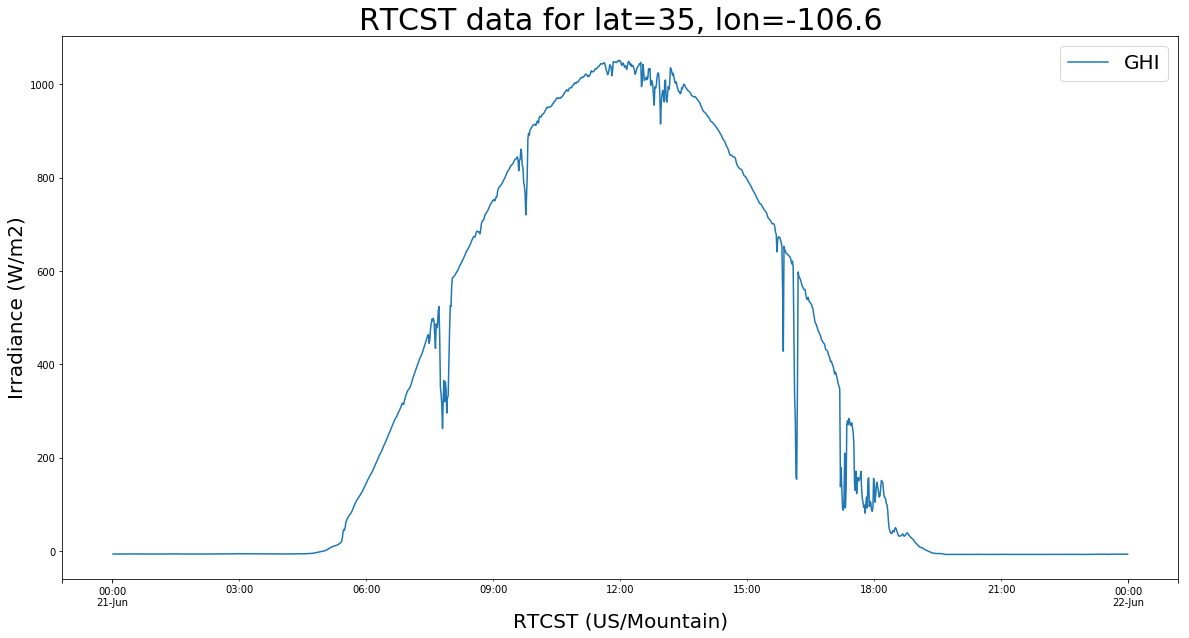

In [28]:
# Plot GHI
irrad_var = ['GHI']
weather_df[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

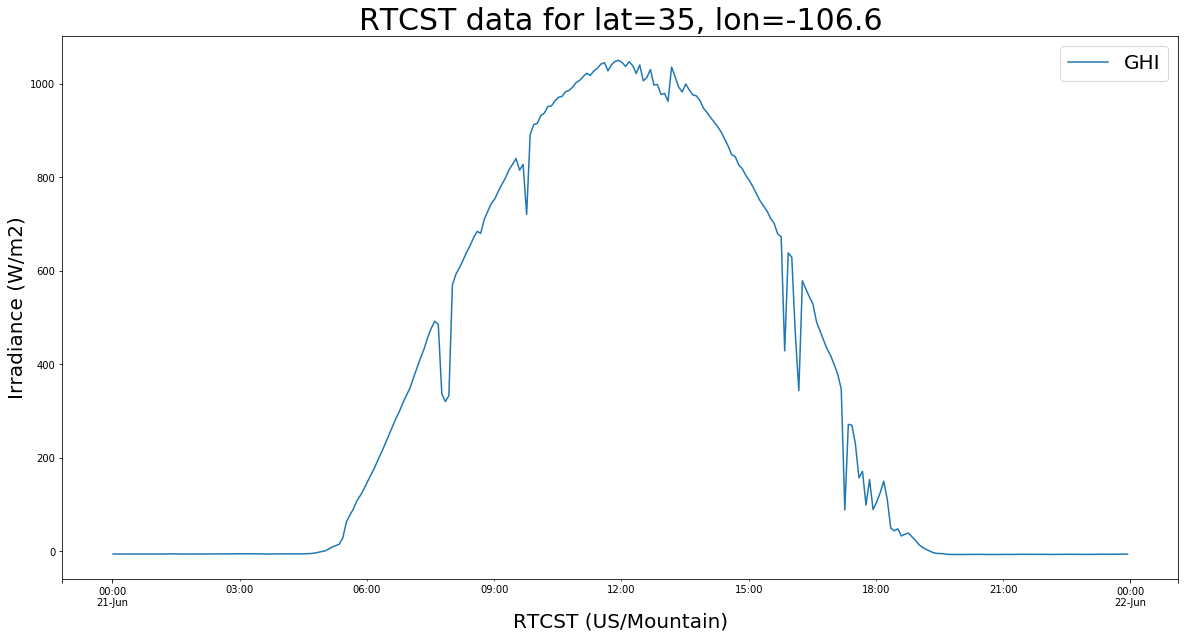

In [29]:
# Plot GHI
irrad_var = ['GHI']
weather_df_slice[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## System PIV June 21

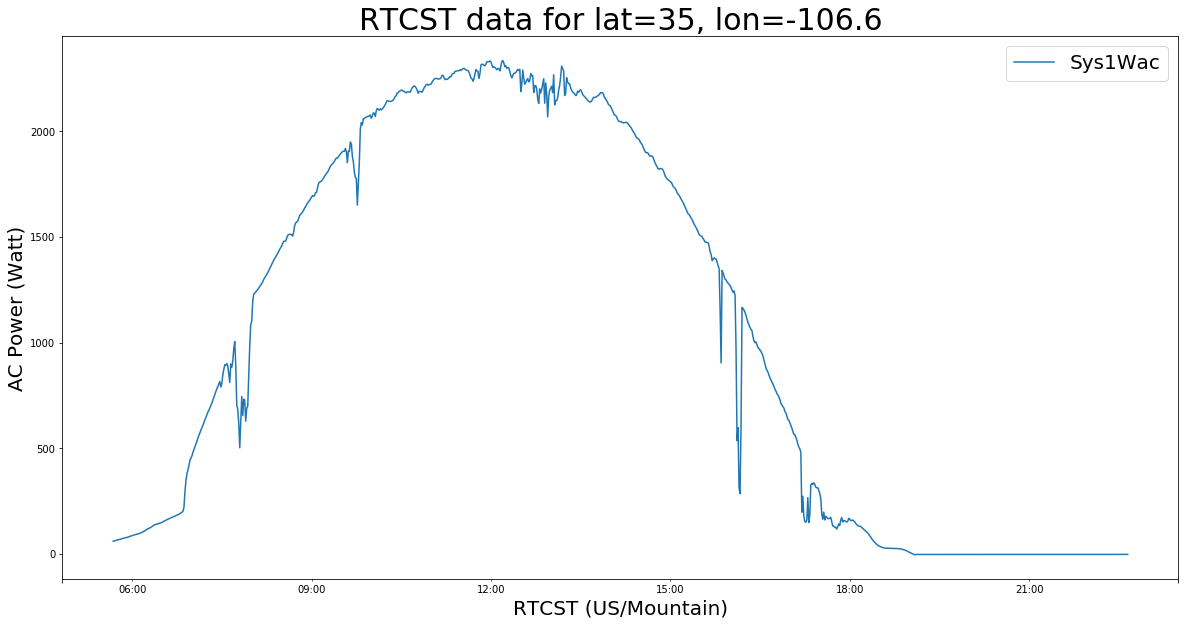

In [30]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

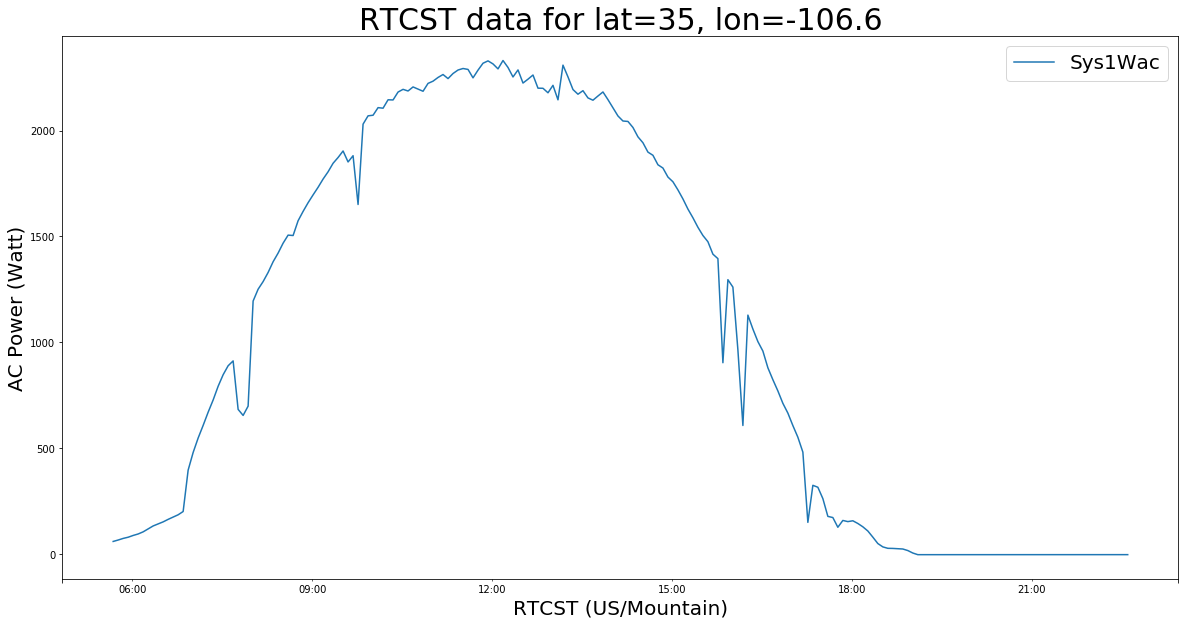

In [31]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

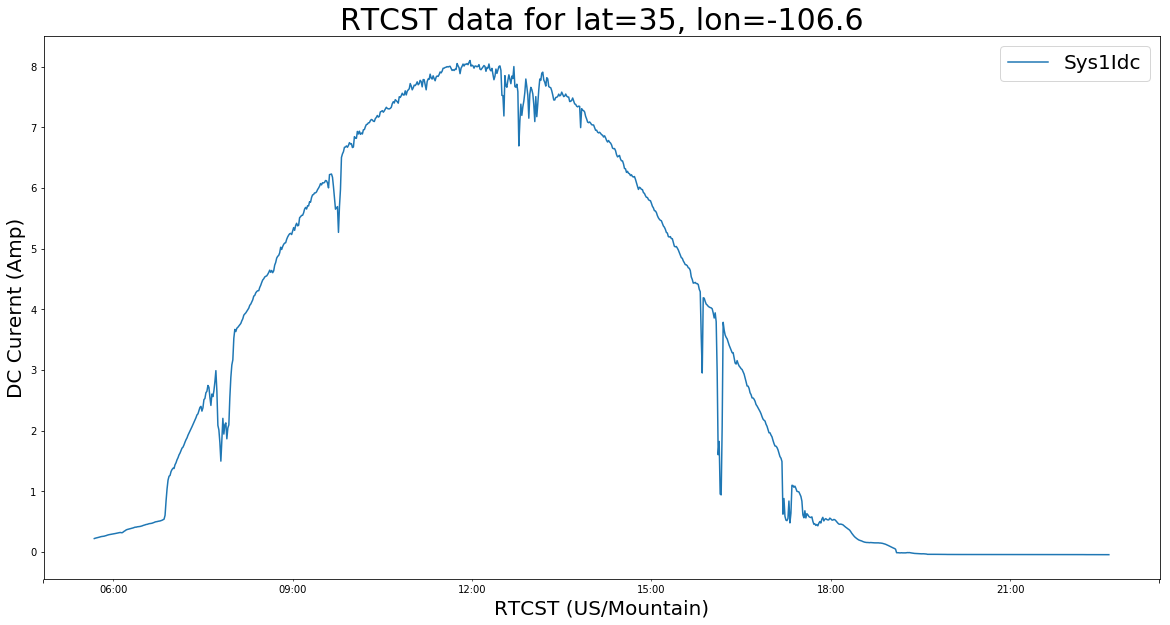

In [32]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

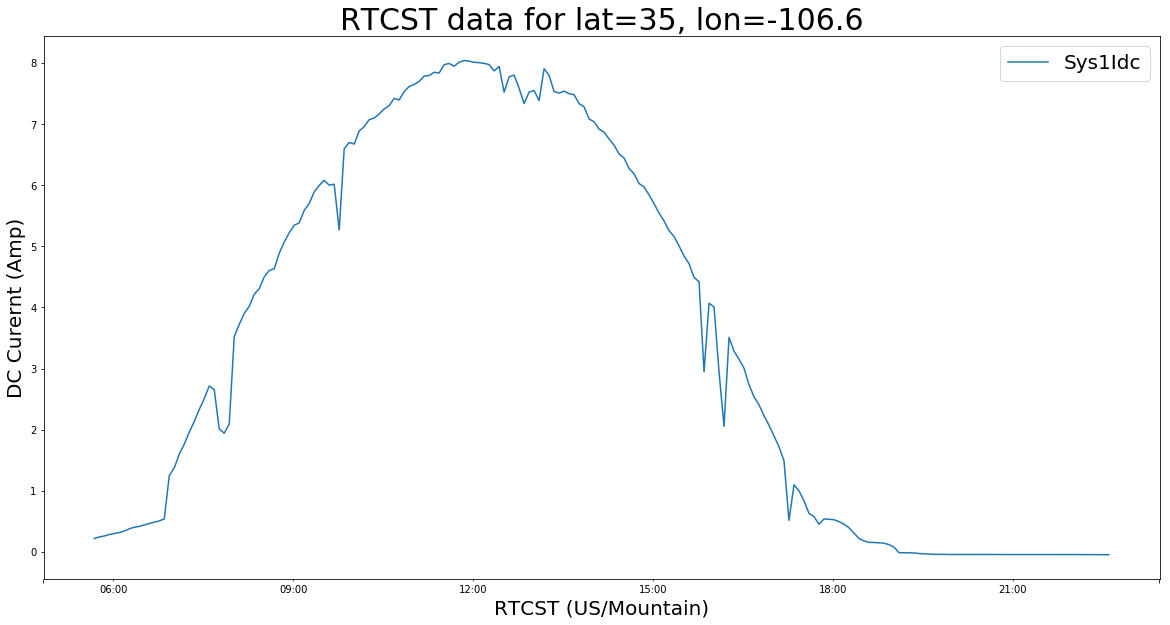

In [33]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

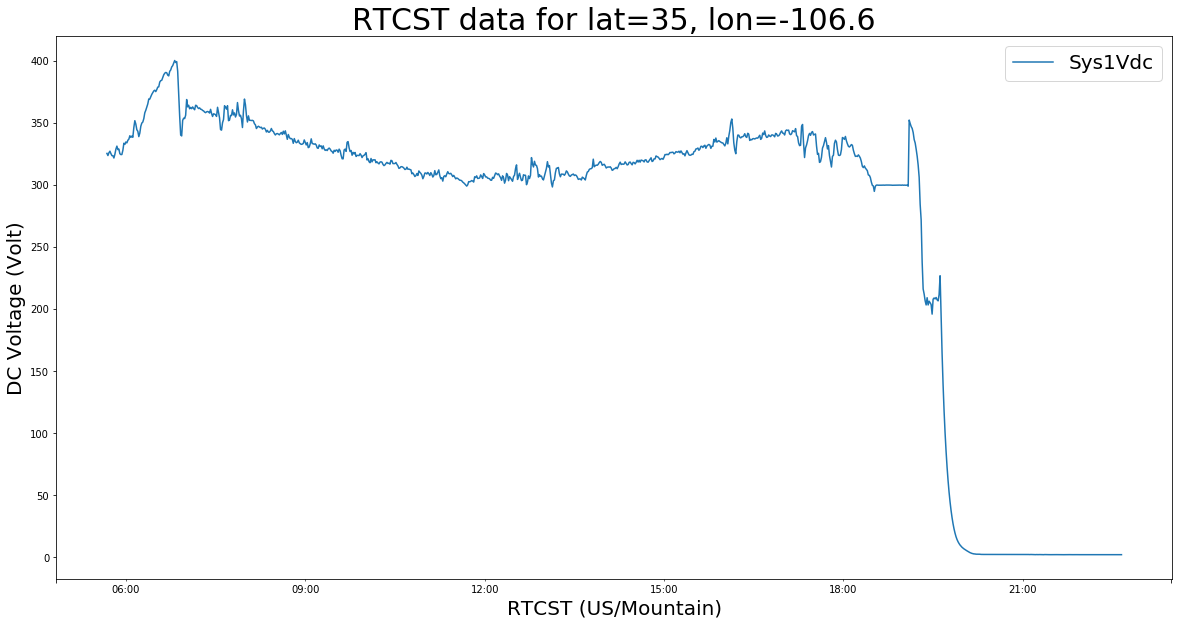

In [34]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

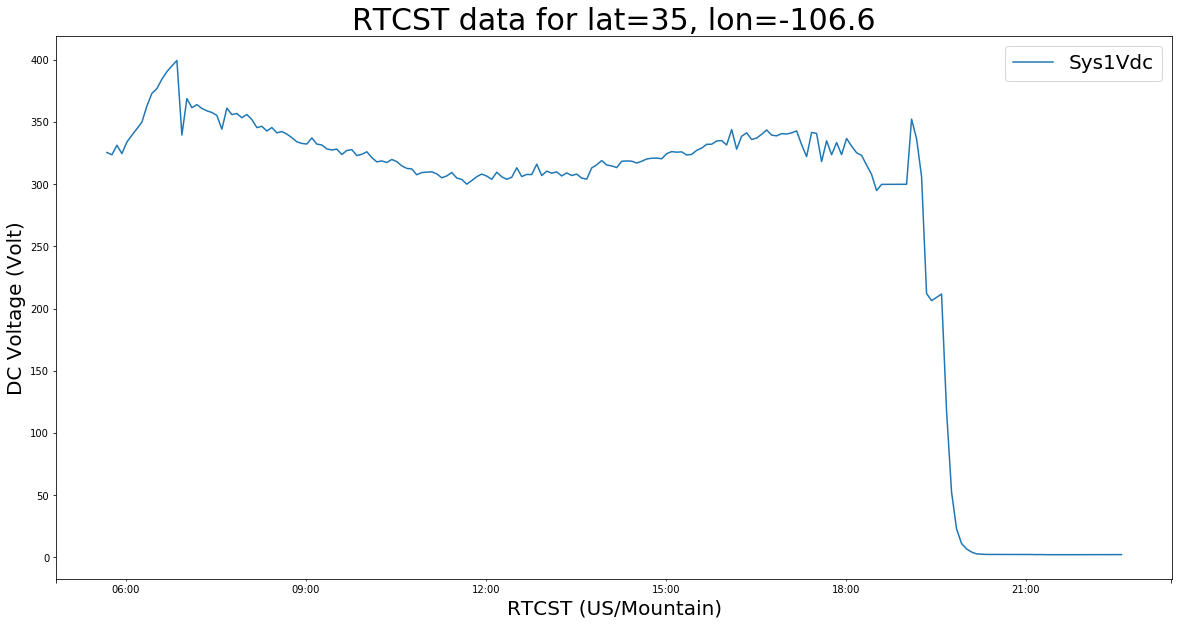

In [35]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df_slice[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## Read HRRR CSV's

In [36]:
# Read HRRR Irradiance CSV
hrrr_df = pd.read_csv('HRRR June 21.csv')
print("Keys of hrrr_df: \n{}".format(hrrr_df.keys()))

Keys of hrrr_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [37]:
hrrr_df.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,450.655978,457.150300,122.632044
std,381.645484,318.082357,100.855627
min,0.000000,0.000000,0.000000
25%,37.794763,64.393394,24.864114
50%,449.292116,657.182850,108.633212
75%,818.012868,709.888719,208.224110
max,971.996899,726.615837,283.323747


In [38]:
hrrr_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-21 06:00:00-06:00,0.334917,0.000000,0.334917
1,2020-06-21 07:00:00-06:00,116.880215,257.573574,65.157616
2,2020-06-21 08:00:00-06:00,319.023941,561.783943,96.497991
3,2020-06-21 09:00:00-06:00,521.738519,695.606425,118.314149
4,2020-06-21 10:00:00-06:00,701.132782,725.585184,164.312374


In [39]:
# Read Forecast AC Power CSV
ac_df = pd.read_csv('AC June 21.csv')
print("Keys of ac_df: \n{}".format(ac_df.keys()))

Keys of ac_df: 
Index(['2020-06-21 06:00:00-06:00', '-1.56'], dtype='object')


In [40]:
ac_df.head()

,2020-06-21 06:00:00-06:00,-1.56
0,2020-06-21 06:05:00-06:00,-1.560000
1,2020-06-21 06:10:00-06:00,-1.560000
2,2020-06-21 06:15:00-06:00,-1.560000
3,2020-06-21 06:20:00-06:00,-1.560000
4,2020-06-21 06:25:00-06:00,-9.245517


In [41]:
# TimeStamp as Index
ac_df.set_index('2020-06-21 06:00:00-06:00', inplace=True)
ac_df.head()

,-1.56
2020-06-21 06:00:00-06:00,
2020-06-21 06:05:00-06:00,-1.560000
2020-06-21 06:10:00-06:00,-1.560000
2020-06-21 06:15:00-06:00,-1.560000
2020-06-21 06:20:00-06:00,-1.560000
2020-06-21 06:25:00-06:00,-9.245517


In [42]:
ac_df.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_df.head()

,AC Power
2020-06-21 06:00:00-06:00,
2020-06-21 06:05:00-06:00,-1.560000
2020-06-21 06:10:00-06:00,-1.560000
2020-06-21 06:15:00-06:00,-1.560000
2020-06-21 06:20:00-06:00,-1.560000
2020-06-21 06:25:00-06:00,-9.245517


In [43]:
ac_df.describe()

,AC Power
count,204.000000
mean,1215.485686
std,974.946836
min,-9.245517
25%,83.622615
50%,1281.146523
75%,2204.248637
max,2518.931756


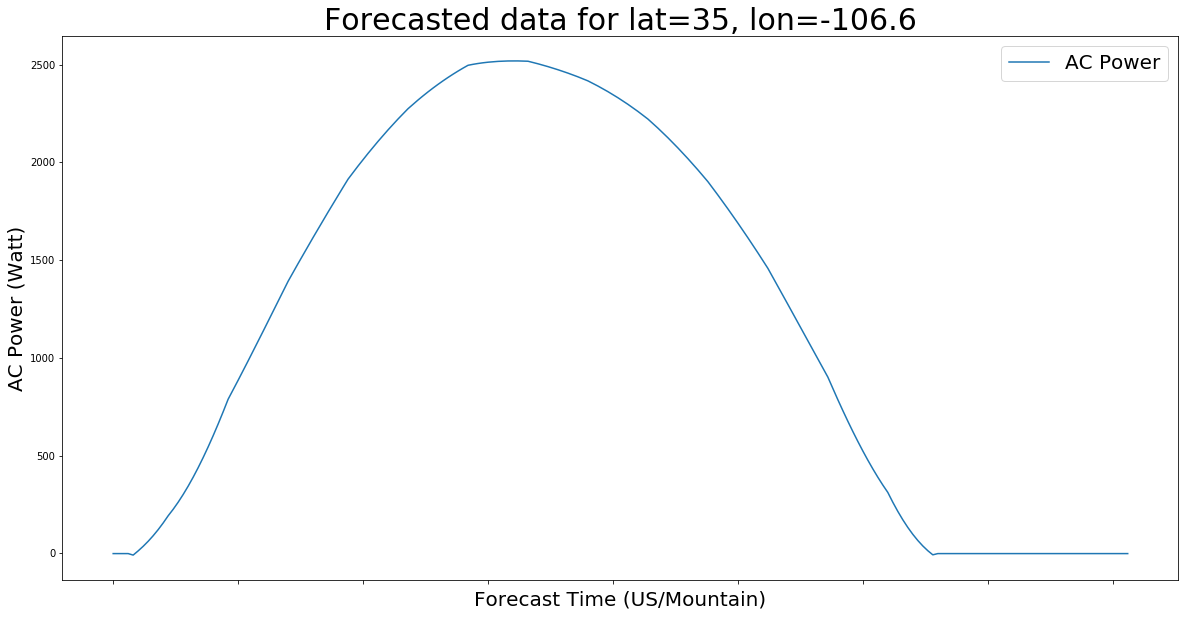

In [44]:
# Plot AC Power
forecast_ac = ['AC Power']
ac_df[forecast_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [45]:
# Read Forecast DC Power CSV
dc_df = pd.read_csv('DC June 21.csv')
print("Keys of dc_df: \n{}".format(dc_df.keys()))

Keys of dc_df: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [46]:
dc_df.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2.386729,2.130191,605.079824,482.334436,1297.709686,2.330660,1.552851
std,1.867482,1.661968,291.696327,237.445502,1016.309008,1.824720,1.184710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.319599,0.288287,685.500297,531.506202,145.864948,0.311329,0.229275
50%,2.486552,2.226075,742.834013,594.222810,1374.379691,2.425857,1.681681
75%,4.286331,3.824308,768.603523,624.711017,2320.659846,4.186954,2.751867
max,4.896505,4.355936,781.577088,636.990002,2652.640694,4.784966,3.088027


In [47]:
dc_df.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-21 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-21 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-21 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-06-21 06:15:00-06:00,0.060941,0.055161,631.746910,391.424765,21.591445,0.059353,0.044018
4,2020-06-21 06:20:00-06:00,0.112471,0.101788,660.416723,460.840799,46.908172,0.109545,0.081127


### Merge DataFrames

In [48]:
# Clear Index
ac_df=ac_df.reset_index()
system_df_slice=system_df_slice.reset_index()

In [49]:
ac_df.head()

,2020-06-21 06:00:00-06:00,AC Power
0,2020-06-21 06:05:00-06:00,-1.560000
1,2020-06-21 06:10:00-06:00,-1.560000
2,2020-06-21 06:15:00-06:00,-1.560000
3,2020-06-21 06:20:00-06:00,-1.560000
4,2020-06-21 06:25:00-06:00,-9.245517


In [50]:
ac_df.describe()

,AC Power
count,204.000000
mean,1215.485686
std,974.946836
min,-9.245517
25%,83.622615
50%,1281.146523
75%,2204.248637
max,2518.931756


In [51]:
system_df_slice.head()

,TimeStamp,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
0,2020-06-21 05:41:00,19.016666,32.831207,32.550571,31.860306,0.2210,325.399994,59.827648,0.24325,363.199982,66.643379
1,2020-06-21 05:46:00,19.933332,35.921204,35.020107,34.209183,0.2450,323.583344,66.585167,0.26900,361.083344,75.308304
2,2020-06-21 05:51:00,20.458334,43.935879,37.083790,36.065163,0.2605,331.250000,74.150978,0.28475,362.616669,80.820229
3,2020-06-21 05:56:00,20.850000,48.377747,39.452526,38.322102,0.2855,324.500000,79.814362,0.30475,362.966644,87.578804
4,2020-06-21 06:01:00,20.966665,51.274624,41.740032,40.542576,0.3005,333.850006,88.157227,0.32750,360.999969,95.768311


In [52]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,30.515441,434.276494,420.367783,417.834218,3.438232,269.041581,1044.404041,3.463603,269.402446,1076.302004
std,4.221459,381.979598,377.845854,377.854331,3.112409,123.914755,919.805935,3.082661,129.769636,938.104909
min,19.016666,-3.476246,0.000000,0.000000,-0.045000,2.200000,-2.716349,0.006000,1.416667,0.000000
25%,27.095832,31.817303,32.451130,31.834486,0.221000,303.845840,57.353796,0.251312,308.016685,64.720129
50%,31.316666,376.400131,344.769852,349.873962,2.842500,318.608337,908.130066,2.857500,321.600006,940.659576
75%,34.133335,839.633957,822.146988,818.836334,6.713625,336.016670,2051.364410,6.783687,342.716644,2091.552673
max,36.116665,995.751221,983.734314,981.514221,8.040750,399.316650,2331.114990,8.042250,371.966675,2406.414551


In [53]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_df['System']=system
ac_df.head()

,2020-06-21 06:00:00-06:00,AC Power,System
0,2020-06-21 06:05:00-06:00,-1.560000,59.827648
1,2020-06-21 06:10:00-06:00,-1.560000,66.585167
2,2020-06-21 06:15:00-06:00,-1.560000,74.150978
3,2020-06-21 06:20:00-06:00,-1.560000,79.814362
4,2020-06-21 06:25:00-06:00,-9.245517,88.157227


In [54]:
# TimeStamp as Index
ac_df.set_index('2020-06-21 06:00:00-06:00', inplace=True)
ac_df.head()

,AC Power,System
2020-06-21 06:00:00-06:00,,
2020-06-21 06:05:00-06:00,-1.560000,59.827648
2020-06-21 06:10:00-06:00,-1.560000,66.585167
2020-06-21 06:15:00-06:00,-1.560000,74.150978
2020-06-21 06:20:00-06:00,-1.560000,79.814362
2020-06-21 06:25:00-06:00,-9.245517,88.157227


In [55]:
# Examine the column labels
all(isinstance(column, str) for column in ac_df.columns)

True

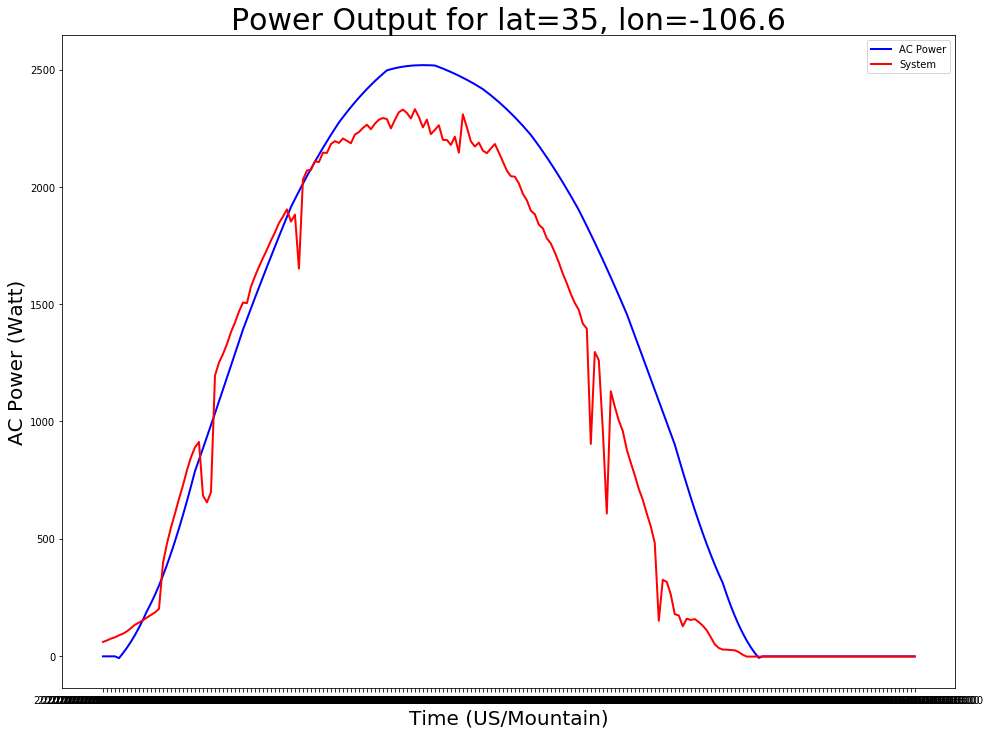

In [56]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_df, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_df, marker='', color='red', linewidth=2);
plt.legend();

## Read NDFD CSV's

In [57]:
# Read NDFD Irradiance CSV
ndfd_df = pd.read_csv('NDFD June 21.csv')
print("Keys of ndfd_df: \n{}".format(ndfd_df.keys()))

Keys of ndfd_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [58]:
ndfd_df.describe()

,ghi,dni,dhi
count,19.000000,19.000000,19.000000
mean,391.937372,323.208755,160.064058
std,354.405557,258.026243,149.305658
min,0.000000,0.000000,0.000000
25%,4.873071,0.000000,4.873071
50%,310.709277,469.698347,131.133749
75%,735.041159,491.039914,259.339818
max,877.227234,678.496130,417.302970


In [59]:
ndfd_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-21 06:00:00-06:00,0.319678,0.000000,0.319678
1,2020-06-21 07:00:00-06:00,111.562160,219.170880,67.551095
2,2020-06-21 08:00:00-06:00,304.508339,486.469781,111.814775
3,2020-06-21 09:00:00-06:00,511.564609,655.959754,131.133749
4,2020-06-21 10:00:00-06:00,687.460681,678.496130,185.478863


In [60]:
# Read Forecast AC Power CSV
ac_ndfd = pd.read_csv('NDFD AC June 21.csv')
print("Keys of ac_ndfd: \n{}".format(ac_ndfd.keys()))

Keys of ac_ndfd: 
Index(['2020-06-21 06:00:00-06:00', '-1.56'], dtype='object')


In [61]:
ac_ndfd.head()

,2020-06-21 06:00:00-06:00,-1.56
0,2020-06-21 06:05:00-06:00,-1.56000
1,2020-06-21 06:10:00-06:00,-1.56000
2,2020-06-21 06:15:00-06:00,-1.56000
3,2020-06-21 06:20:00-06:00,-1.56000
4,2020-06-21 06:25:00-06:00,-8.66272


In [62]:
# TimeStamp as Index
ac_ndfd.set_index('2020-06-21 06:00:00-06:00', inplace=True)
ac_ndfd.head()

,-1.56
2020-06-21 06:00:00-06:00,
2020-06-21 06:05:00-06:00,-1.56000
2020-06-21 06:10:00-06:00,-1.56000
2020-06-21 06:15:00-06:00,-1.56000
2020-06-21 06:20:00-06:00,-1.56000
2020-06-21 06:25:00-06:00,-8.66272


In [63]:
ac_ndfd.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_ndfd.head()

,AC Power
2020-06-21 06:00:00-06:00,
2020-06-21 06:05:00-06:00,-1.56000
2020-06-21 06:10:00-06:00,-1.56000
2020-06-21 06:15:00-06:00,-1.56000
2020-06-21 06:20:00-06:00,-1.56000
2020-06-21 06:25:00-06:00,-8.66272


In [64]:
ac_ndfd.describe()

,AC Power
count,216.000000
mean,1052.296099
std,907.751656
min,-8.662720
25%,-1.560000
50%,1025.023397
75%,2013.945723
max,2293.443042


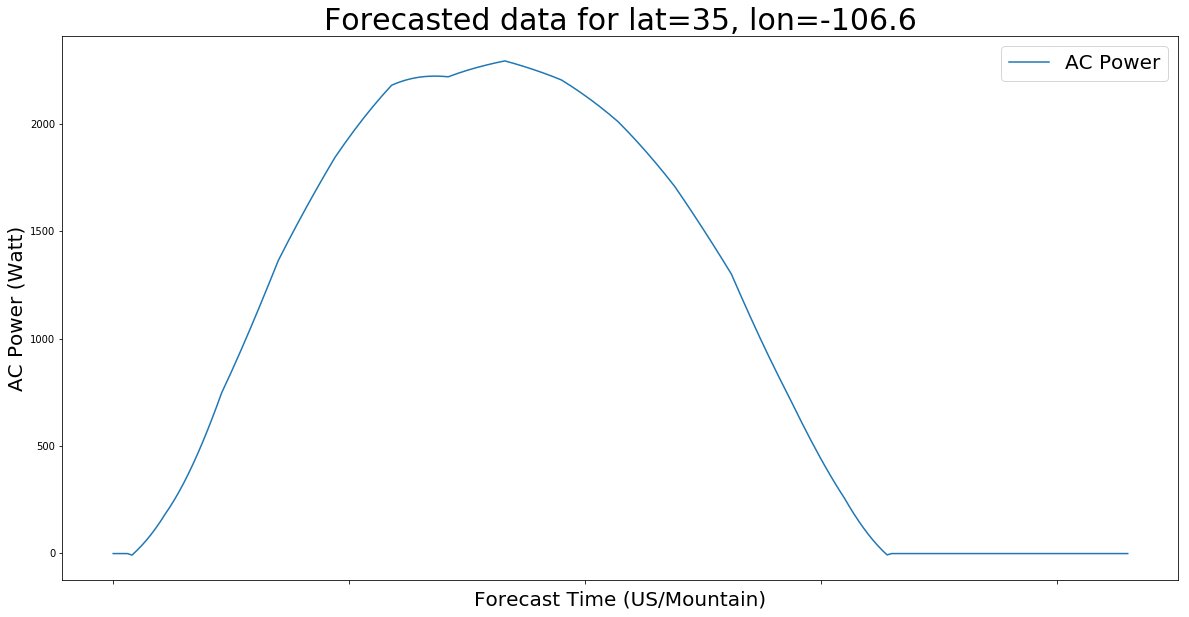

In [65]:
# Plot AC Power
ndfd_ac = ['AC Power']
ac_ndfd[ndfd_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [66]:
# Read Forecast DC Power CSV
dc_ndfd = pd.read_csv('NDFD DC June 21.csv')
print("Keys of dc_ndfd: \n{}".format(dc_ndfd.keys()))

Keys of dc_ndfd: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [67]:
dc_ndfd.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,2.075787,1.854297,568.321707,453.135647,1128.248020,2.026580,1.362947
std,1.738415,1.549327,313.843747,255.217122,949.174335,1.698052,1.118218
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.114818,0.103865,624.738485,408.652105,46.284671,0.111831,0.082815
50%,2.011384,1.807826,740.321820,597.111653,1103.243479,1.961655,1.378049
75%,3.934707,3.511971,765.377132,615.034286,2127.565128,3.842534,2.552682
max,4.416608,3.935809,770.814362,633.346641,2420.612175,4.314580,2.825182


In [68]:
dc_ndfd.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-21 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-21 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-21 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-06-21 06:15:00-06:00,0.062446,0.056497,624.738485,383.190893,21.649267,0.060819,0.045103
4,2020-06-21 06:20:00-06:00,0.114818,0.103865,653.864259,453.361371,47.088572,0.111831,0.082815


### Merge DataFrames

In [69]:
# Clear Index
ac_ndfd=ac_ndfd.reset_index()

In [70]:
ac_ndfd.head()

,2020-06-21 06:00:00-06:00,AC Power
0,2020-06-21 06:05:00-06:00,-1.56000
1,2020-06-21 06:10:00-06:00,-1.56000
2,2020-06-21 06:15:00-06:00,-1.56000
3,2020-06-21 06:20:00-06:00,-1.56000
4,2020-06-21 06:25:00-06:00,-8.66272


In [71]:
ac_ndfd.describe()

,AC Power
count,216.000000
mean,1052.296099
std,907.751656
min,-8.662720
25%,-1.560000
50%,1025.023397
75%,2013.945723
max,2293.443042


In [72]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_ndfd['System']=system
ac_ndfd.head()

,2020-06-21 06:00:00-06:00,AC Power,System
0,2020-06-21 06:05:00-06:00,-1.56000,59.827648
1,2020-06-21 06:10:00-06:00,-1.56000,66.585167
2,2020-06-21 06:15:00-06:00,-1.56000,74.150978
3,2020-06-21 06:20:00-06:00,-1.56000,79.814362
4,2020-06-21 06:25:00-06:00,-8.66272,88.157227


In [74]:
# TimeStamp as Index
ac_ndfd.set_index('2020-06-21 06:00:00-06:00', inplace=True)
ac_ndfd.head()

,AC Power,System
2020-06-21 06:00:00-06:00,,
2020-06-21 06:05:00-06:00,-1.56000,59.827648
2020-06-21 06:10:00-06:00,-1.56000,66.585167
2020-06-21 06:15:00-06:00,-1.56000,74.150978
2020-06-21 06:20:00-06:00,-1.56000,79.814362
2020-06-21 06:25:00-06:00,-8.66272,88.157227


In [75]:
# Examine the column labels
all(isinstance(column, str) for column in ac_ndfd.columns)

True

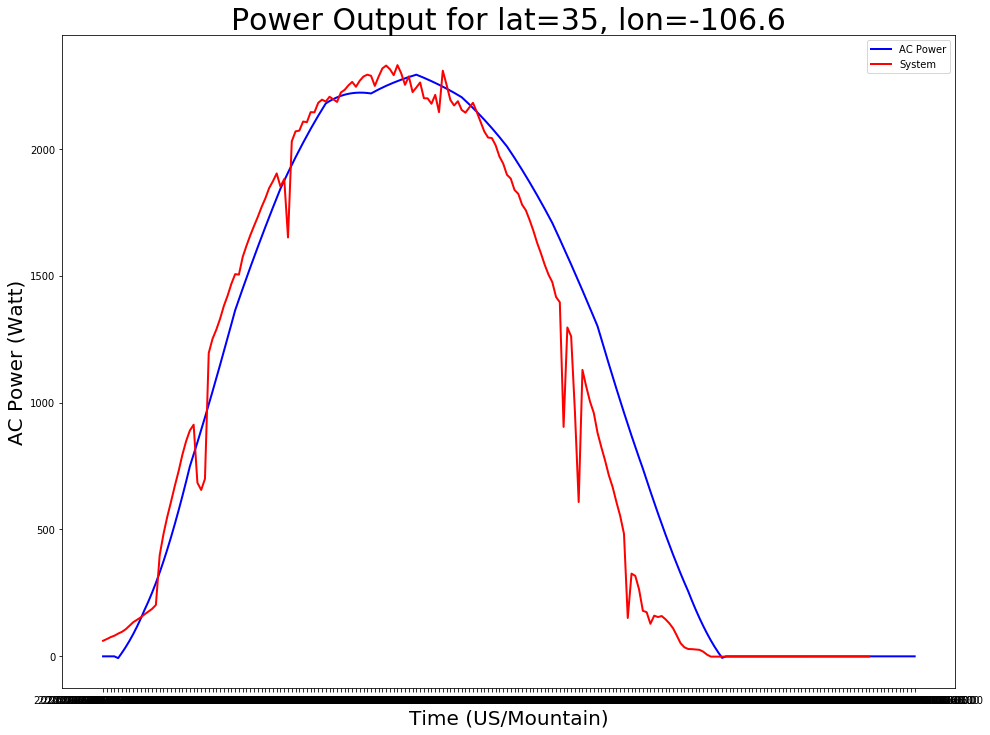

In [76]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_ndfd, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_ndfd, marker='', color='red', linewidth=2);
plt.legend();

## Error
### Mean Square Error

In [ ]:
y_true= system_df_slice['Sys1Wac']
y_pred= ac_df['AC Power']
print('Mean Square Error:\n',mean_squared_error(y_true, y_pred))